In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection_lgbm = json.load(f)

with open('../feat_selection/select_optuna_catb.json', 'r') as f:
    feature_selection_catb = json.load(f)

# Extract the selected features
numerical_cols = feature_selection_lgbm.get('numerical', [])
categorical_cols = feature_selection_lgbm.get('categorical', [])

# numerical_cols = list(set(feature_selection_lgbm.get('numerical', []) + feature_selection_catb.get('numerical', [])))
# categorical_cols = list(set(feature_selection_lgbm.get('categorical', []) + feature_selection_catb.get('categorical', [])))

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 0


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 368
Categorical Columns: 5


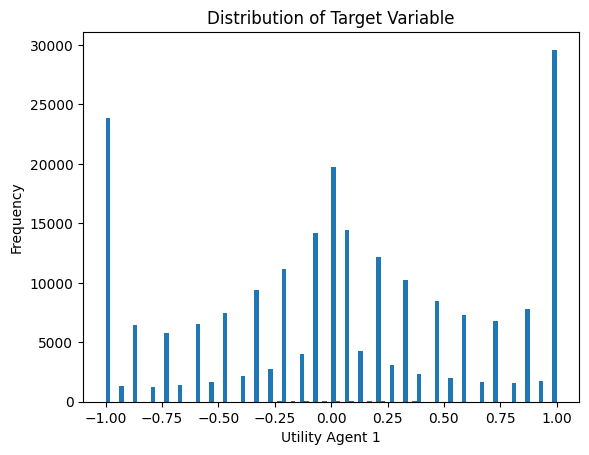

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [7]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [8]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1
0:	learn: 0.6130379	test: 0.5464143	best: 0.5464143 (0)	total: 144ms	remaining: 7m 13s
50:	learn: 0.3875128	test: 0.4648319	best: 0.4648319 (50)	total: 3.88s	remaining: 3m 44s
100:	learn: 0.3518160	test: 0.4468953	best: 0.4468953 (100)	total: 7.8s	remaining: 3m 43s
150:	learn: 0.3310630	test: 0.4390077	best: 0.4390077 (150)	total: 11.6s	remaining: 3m 38s
200:	learn: 0.3177345	test: 0.4347845	best: 0.4347755 (199)	total: 15.5s	remaining: 3m 35s
250:	learn: 0.3066207	test: 0.4311939	best: 0.4311939 (250)	total: 19.3s	remaining: 3m 31s
300:	learn: 0.2981742	test: 0.4293132	best: 0.4293132 (300)	total: 23.1s	remaining: 3m 27s
350:	learn: 0.2910264	test: 0.4278743	best: 0.4278623 (349)	total: 27.1s	remaining: 3m 24s
400:	learn: 0.2851502	test: 0.4268852	best: 0.4268625 (398)	total: 31.1s	remaining: 3m 21s
450:	learn: 0.2794802	test: 0.4262299	best: 0.4262299 (450)	total: 35s	remaining: 3m 17s
500:	learn: 0.2743013	test: 0.4256722	best: 0.4256632 (499)	total: 38.9s	remaining: 3m 14s
5

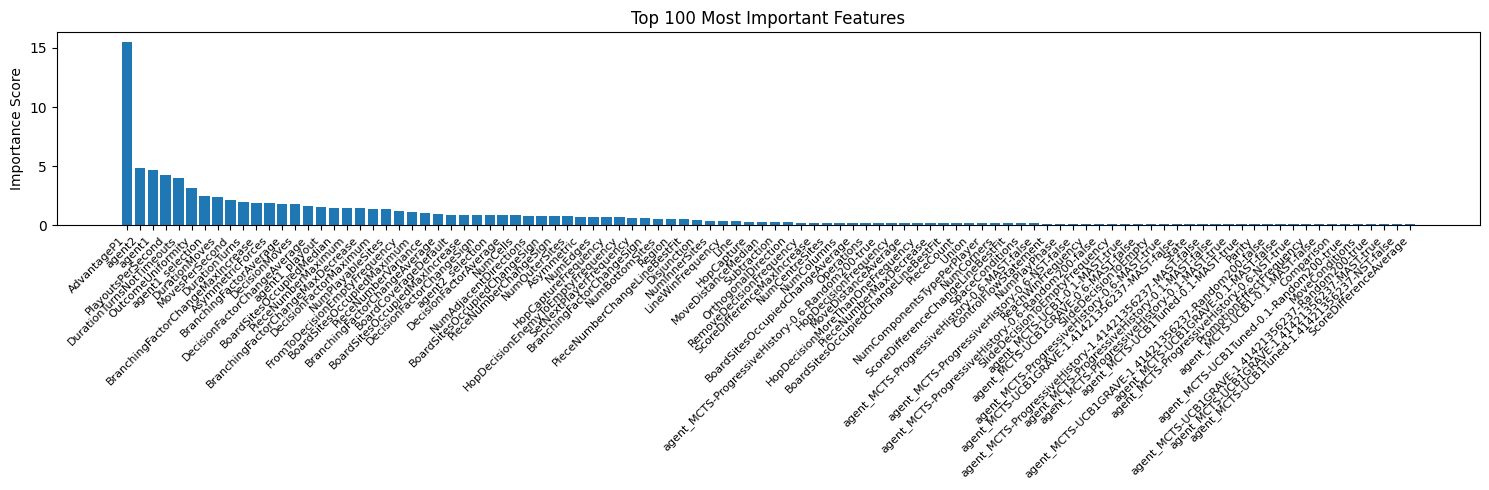

Fold 1 - RMSE: 0.42020773720267796
Fold 2
0:	learn: 0.6070205	test: 0.5814626	best: 0.5814626 (0)	total: 136ms	remaining: 6m 47s
50:	learn: 0.3910868	test: 0.4689778	best: 0.4689701 (49)	total: 3.89s	remaining: 3m 45s
100:	learn: 0.3560301	test: 0.4552468	best: 0.4552468 (100)	total: 7.94s	remaining: 3m 48s
150:	learn: 0.3356976	test: 0.4480882	best: 0.4480520 (149)	total: 12s	remaining: 3m 46s
200:	learn: 0.3223269	test: 0.4453940	best: 0.4451681 (198)	total: 16.3s	remaining: 3m 46s
250:	learn: 0.3131616	test: 0.4436296	best: 0.4436026 (249)	total: 20.5s	remaining: 3m 44s
300:	learn: 0.3043642	test: 0.4419565	best: 0.4419565 (300)	total: 24.6s	remaining: 3m 40s
350:	learn: 0.2977004	test: 0.4408360	best: 0.4408360 (350)	total: 28.8s	remaining: 3m 37s
400:	learn: 0.2912467	test: 0.4397084	best: 0.4396781 (392)	total: 32.9s	remaining: 3m 33s
450:	learn: 0.2858596	test: 0.4388685	best: 0.4388616 (446)	total: 37.1s	remaining: 3m 29s
500:	learn: 0.2805769	test: 0.4380378	best: 0.4380378 (5

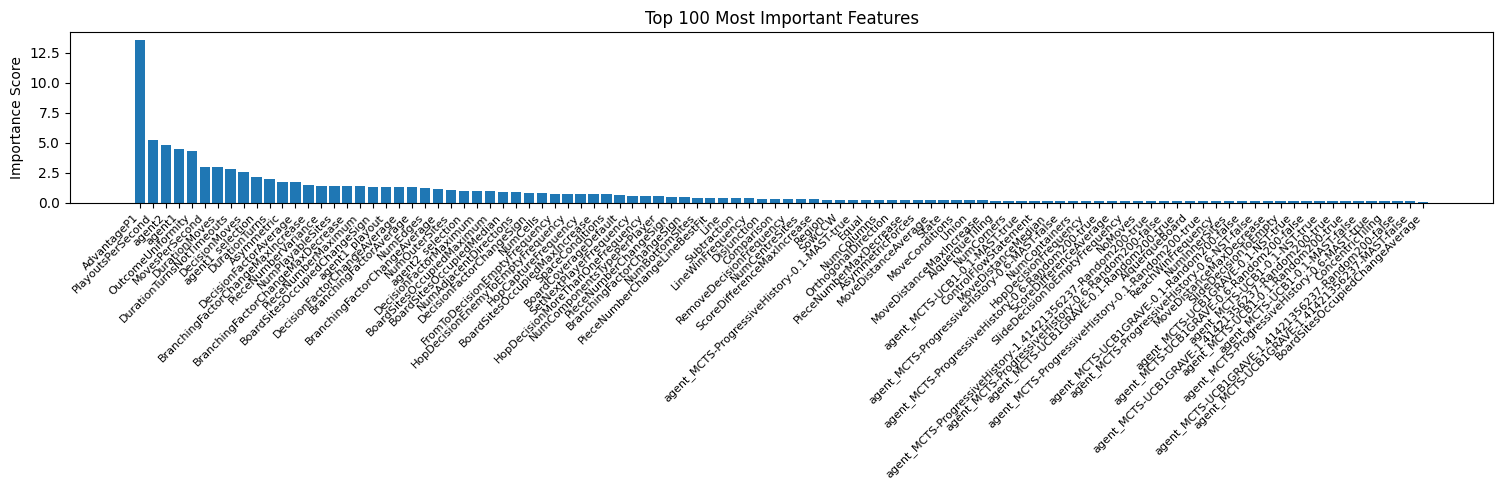

Fold 2 - RMSE: 0.4324039841045965
Fold 3
0:	learn: 0.6030314	test: 0.5940548	best: 0.5940548 (0)	total: 80.2ms	remaining: 4m
50:	learn: 0.3897491	test: 0.4615203	best: 0.4615203 (50)	total: 5.25s	remaining: 5m 3s
100:	learn: 0.3553736	test: 0.4478142	best: 0.4478142 (100)	total: 10.2s	remaining: 4m 53s
150:	learn: 0.3353906	test: 0.4399086	best: 0.4399086 (150)	total: 15.4s	remaining: 4m 49s
200:	learn: 0.3218403	test: 0.4359832	best: 0.4359751 (199)	total: 20.1s	remaining: 4m 39s
250:	learn: 0.3114869	test: 0.4331271	best: 0.4330540 (242)	total: 24.8s	remaining: 4m 31s
300:	learn: 0.3028182	test: 0.4309089	best: 0.4309089 (300)	total: 29.6s	remaining: 4m 25s
350:	learn: 0.2955684	test: 0.4294258	best: 0.4294160 (349)	total: 34.5s	remaining: 4m 20s
400:	learn: 0.2890016	test: 0.4281490	best: 0.4281490 (400)	total: 39.2s	remaining: 4m 14s
450:	learn: 0.2832360	test: 0.4270380	best: 0.4270380 (450)	total: 44.1s	remaining: 4m 9s
500:	learn: 0.2783975	test: 0.4261045	best: 0.4260506 (498)	

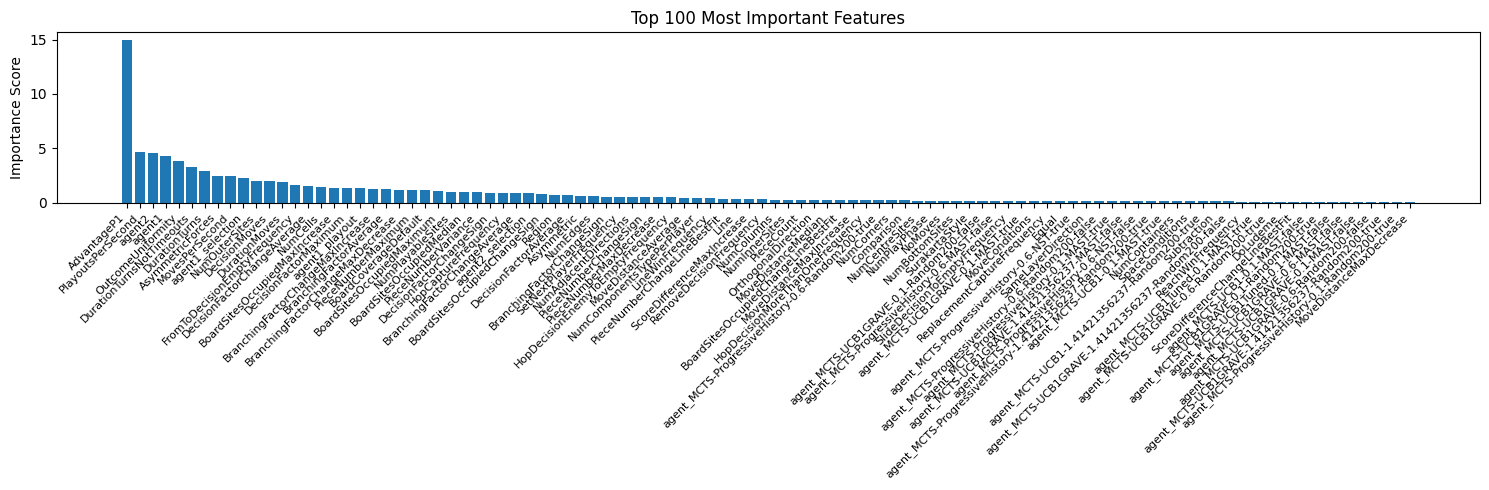

Fold 3 - RMSE: 0.4200207824980687
Fold 4
0:	learn: 0.6039636	test: 0.5895320	best: 0.5895320 (0)	total: 83.5ms	remaining: 4m 10s
50:	learn: 0.3905929	test: 0.4869394	best: 0.4869394 (50)	total: 4.29s	remaining: 4m 7s
100:	learn: 0.3540465	test: 0.4680040	best: 0.4680040 (100)	total: 8.72s	remaining: 4m 10s
150:	learn: 0.3344172	test: 0.4595062	best: 0.4595062 (150)	total: 13.1s	remaining: 4m 6s
200:	learn: 0.3212544	test: 0.4551081	best: 0.4551081 (200)	total: 17.5s	remaining: 4m 4s
250:	learn: 0.3094175	test: 0.4523947	best: 0.4523834 (249)	total: 22.4s	remaining: 4m 5s
300:	learn: 0.3009227	test: 0.4506232	best: 0.4506232 (300)	total: 26.7s	remaining: 3m 59s
350:	learn: 0.2930348	test: 0.4495232	best: 0.4495232 (350)	total: 31.1s	remaining: 3m 54s
400:	learn: 0.2864842	test: 0.4484430	best: 0.4484430 (400)	total: 35.4s	remaining: 3m 49s
450:	learn: 0.2808861	test: 0.4471953	best: 0.4471953 (450)	total: 39.9s	remaining: 3m 45s
500:	learn: 0.2758077	test: 0.4464822	best: 0.4464599 (499

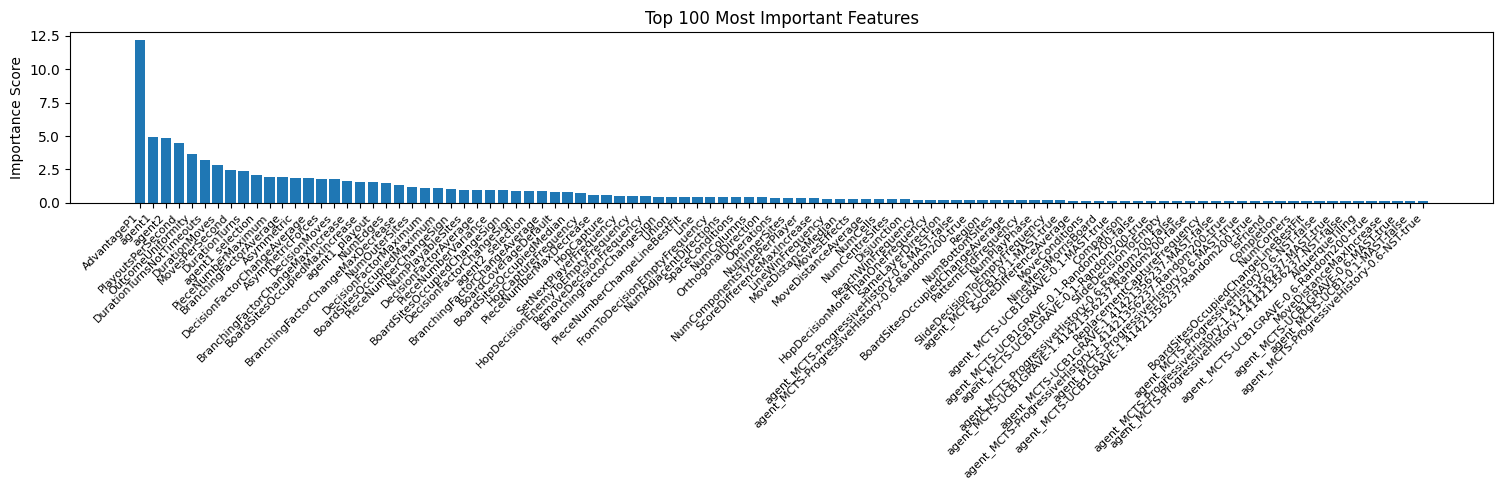

Fold 4 - RMSE: 0.43883002408231137
Fold 5
0:	learn: 0.6147761	test: 0.5421670	best: 0.5421670 (0)	total: 65.2ms	remaining: 3m 15s
50:	learn: 0.3972719	test: 0.4511908	best: 0.4511908 (50)	total: 4s	remaining: 3m 51s
100:	learn: 0.3620085	test: 0.4345235	best: 0.4345235 (100)	total: 8.35s	remaining: 3m 59s
150:	learn: 0.3426609	test: 0.4294069	best: 0.4292779 (149)	total: 12.5s	remaining: 3m 56s
200:	learn: 0.3293185	test: 0.4256268	best: 0.4256268 (200)	total: 16.8s	remaining: 3m 54s
250:	learn: 0.3193572	test: 0.4233102	best: 0.4233102 (250)	total: 21s	remaining: 3m 49s
300:	learn: 0.3108109	test: 0.4213366	best: 0.4213159 (298)	total: 25.2s	remaining: 3m 45s
350:	learn: 0.3026680	test: 0.4199681	best: 0.4199681 (350)	total: 29.4s	remaining: 3m 41s
400:	learn: 0.2956587	test: 0.4183091	best: 0.4182347 (398)	total: 33.7s	remaining: 3m 38s
450:	learn: 0.2889983	test: 0.4170421	best: 0.4170421 (450)	total: 37.8s	remaining: 3m 33s
500:	learn: 0.2834628	test: 0.4162888	best: 0.4162804 (496

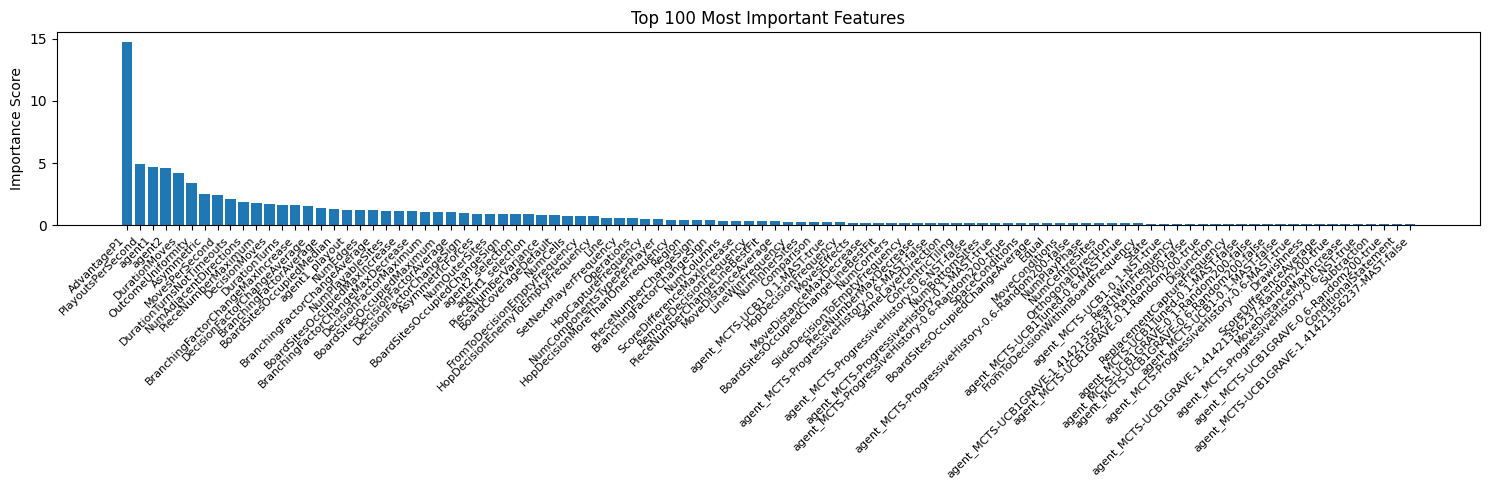

Fold 5 - RMSE: 0.40878595673292617
List of oof scores: [0.42020773720267796, 0.4324039841045965, 0.4200207824980687, 0.43883002408231137, 0.40878595673292617]
Average oof score: 0.42404969692411615


In [9]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_catboost_cv1.csv', index=False)
# save feature importance
importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

In [10]:
# # call the function
# trained_models3, oof3, oof_scores3 = train_models(
#     df_train, 
#     numerical_cols, 
#     categorical_cols, 
#     text_cols=text_cols,
#     split_list=split3,
# )
# # save oof predictions
# oof3.to_csv(path_results / 'oof_catboost_cv3.csv', index=False)

In [11]:
# trained_models = [*trained_models1, *trained_models2, *trained_models3]
trained_models = trained_models1

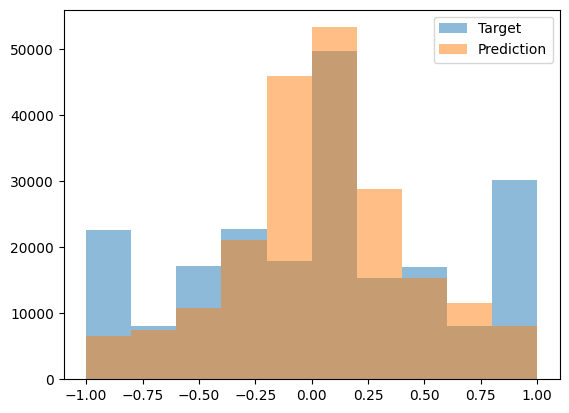

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols + text_cols],
        # data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.104845
233235,-0.156674
233236,-0.066319


In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
